# Investigating Bug Reports Resolution on Bugzilla

This Jupyter Notebook has the code for reproducing the experiment used in the master thesis.

### Dependencies

In [1]:
import sklearn

import numpy as np
import pandas as pd

# evaluate random forest algorithm for classification
from numpy import mean
from numpy import std
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import pickle


# plot
from matplotlib import pyplot as plt
import altair as alt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# models
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# data balancing
from imblearn.over_sampling import RandomOverSampler

#### Loading dataset

In [2]:
data_raw = None
train = pd.read_csv('../data/train_balnced_no_test.csv')
test = pd.read_csv('../data/test_umbalanced.csv')

Removing some unwatend features

In [3]:
train = train.drop(['status_RESOLVED', 'status_VERIFIED', 'changes_status', 'changes_resolution'], axis=1)
test = test.drop(['status_RESOLVED', 'status_VERIFIED', 'changes_status', 'changes_resolution'], axis=1)

# Data Processing

In [ ]:
data = pd.DataFrame.copy(data_raw)

In [ ]:
# filing the null values whit empty string

data['description'].fillna('', inplace=True)
data['total_words_desc'] = data.apply(lambda row: len(list(tokenize(row['description']))), axis=1)

data['summary'].fillna('', inplace=True)
data['total_words_summary'] = data.apply(lambda row: len(list(tokenize(row['summary']))), axis=1)

# removing features that have mostly empty values
data.drop("type", inplace=True, axis=1)
data.drop("flags", inplace=True, axis=1)
data.drop("assigned_to", inplace=True, axis=1)
data.drop("creator", inplace=True, axis=1)
data.drop("description", inplace=True, axis=1)
data.drop("summary", inplace=True, axis=1)
data.drop("id", inplace=True, axis=1)
data.drop("creation_time", inplace=True, axis=1)
data.drop("last_change_time", inplace=True, axis=1)

#Target feature
target_feature = data[["resolution"]]
data.drop("resolution", inplace=True, axis=1)

### Transforming non-numeric features in dummy features

In [ ]:
data = pd.get_dummies(data)
data.head(5)

# Data Balancing

For balancind the data the follwoing chunks must be executed.
X_ros - data balanced
y_ros - labels

In [ ]:
ros = RandomOverSampler()
X = data.drop('label', axis=1)
X_ros, y_ros = ros.fit_resample(X, data['label'])

### Util
Functions

In [4]:
def get_data(path):
    return [pd.read_csv(path + "train.csv"), pd.read_csv(path + "test.csv")]


def show_distribution_graph(df):
    df = df['label'].value_counts().to_frame()
    df = df.reset_index().rename(columns={"index": "Resolution", "label": "Total"})

    return alt.Chart(df).mark_bar().encode(
        x=alt.X('Resolution', sort='-y'),
        y='Total',
        color = alt.value("#ac97b4")
    )

def print_metrics(model, model_name, metrics, x_test, y_test, classes):
    print(f"{model_name} Metrics:\n")
    for i in range(4):
        print(f"{metrics['Metrics'][i]} score is:\t{round(metrics['Scores'][i] * 100,2)}%")
    print("\n")

    confusion_matrix = plot_confusion_matrix(model, x_test, y_test, labels=classes, cmap=plt.cm.Blues, xticks_rotation = "vertical")

    return confusion_matrix

def compute_metrics(pred, y_test):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average='weighted')
    recall = recall_score(y_test, pred, average='weighted')
    f1 = f1_score(y_test, pred, average='weighted')

    return {"Metrics": ["Accuracy", "Precision", "Recall", "F1"], "Scores": [accuracy, precision, recall, f1]}


def compute_metrics_per_class(pred, y_test):

    # Print the confusion matrix
    print(metrics.confusion_matrix(y_test, pred))

    # Print the precision and recall, among other metrics
    print(metrics.classification_report(y_test, pred, digits=2))

def get_metrics(model, model_name, x_train, y_train, x_test, y_test, classes):
    model.fit(x_train, y_train)
    pred = model.predict(x_test)

    metrics = compute_metrics(pred,  y_test)
    print_metrics(model, model_name, metrics, x_test, y_test, classes)
    compute_metrics_per_class(pred, y_test)

    return metrics['Scores']


def get_metric_data(models, models_names):
    # models: [NB_metrics,LG_metrics,DT_metrics,RF_metrics, GB_metrics]
    # TODO: fix this method
    metrics = np.array(models).flatten()
    metrics = list(map(lambda x: x*100, metrics))

    data = {"Metric":
            ['Accuracy', 'Precision', 'Recall', 'F1 Score'] * 5,
            "Metric Score": metrics,
            "Model":
            ['Naive Bayes'] * 4 +
            ['Logistic Regression'] * 4 +
            ['Decision Tree'] * 4 +
            ['Random Forest'] * 4 +
            ['Gradient Boosting'] * 4
        }

    return pd.DataFrame(data)


def plot_metric_graph(data):
    g = sns.catplot(
        data=data,
        kind="bar", x="Metric", y="Metric Score", hue="Model",
        ci="sd", alpha=.6, height=6
    )
    g.set(ylim=(0, 100))
    g.despine(left=True)


def get_params(model_name):
    if (model_name == "Logistic Regression"):
        return { 'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0] }
    elif (model_name == "Gradient Boosting"):
        return {
            'n_estimators': [50, 100],
            'max_depth': [3, 8],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 5],
            'max_features': [None, 5],
            'subsample': [0.5, 1]
            }
    else:
        return { 'max_depth': [None, 15, 35, 50], 'max_leaf_nodes': [None, 250, 500, 750, 1000, 5000]}

def print_best_params(model_name, grid, folds):
    print(f'Hyperparams of {model_name}:\n')
    print(f'Got accuracy score of {grid.best_score_} in {folds}-fold')
    if (model_name == "Logistic Regression"):
        print(f'Best C: {grid.best_params_["C"]}')
    elif (model_name == "Gradient Boosting"):
        print(f'Best max depth: {grid.best_params_["max_depth"]}. Best number of estimators: {grid.best_params_["n_estimators"]}')
        print(f'Best min sample split: {grid.best_params_["min_samples_split"]}. Best min sample leaf: {grid.best_params_["min_samples_leaf"]}')
        print(f'Best max features: {grid.best_params_["max_features"]}. Best subsample: {grid.best_params_["subsample"]}')
    else:
        print(f'Best depth: {grid.best_params_["max_depth"]}. Best number of leafs: {grid.best_params_["max_leaf_nodes"]}')

def get_tuned_metrics(model, model_name, folds, x_train, y_train, x_test, y_test, classes):
    params = get_params(model_name)

    grid = GridSearchCV(model, params, cv = folds)
    grid.fit(x_train, y_train)
    pred = grid.predict(x_test)

    print_best_params(model_name, grid, folds)
    metrics = compute_metrics(pred, y_test)
    print_metrics(grid, model_name, metrics, x_test, y_test, classes)
    return metrics['Scores'], pred

### Data analisys

Balanced train distribution

In [5]:
show_distribution_graph(train)

alt.Chart(...)

Test distribution

In [6]:
show_distribution_graph(test)

alt.Chart(...)

### Machine Learning Models

In [5]:
NB = GaussianNB()
LG = LogisticRegression(max_iter=5000)
DT = DecisionTreeClassifier()
RF = RandomForestClassifier(random_state=42)
GB = GradientBoostingClassifier(random_state=0)

Classification artifacts

In [6]:
x_train = train.drop('label', axis=1)
x_test = test.drop('label', axis=1)
y_train = train['label']
y_test = test['label']
classes = train['label'].unique()

#### Gaussian Naive Bayers

Naive Bayes Metrics:

Accuracy score is:	12.35%
Precision score is:	66.04%
Recall score is:	12.35%
F1 score is:	14.11%




/local_home/manel_local/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


[[ 279   12    8   30    1  341  636    3]
 [1038  813  225   77    4 3198 3108   25]
 [   9    0    0    1    0    8   22    2]
 [ 269    5    1   22    0   56  350    9]
 [  88    3    1    6    0   79  273    2]
 [   0    0    0    0    0    7    0    0]
 [ 133    8    3    6    0   80  495    3]
 [ 367   18   11   50    3  243  756   15]]
              precision    recall  f1-score   support

   DUPLICATE       0.13      0.21      0.16      1310
       FIXED       0.95      0.10      0.17      8488
    INACTIVE       0.00      0.00      0.00        42
  INCOMPLETE       0.11      0.03      0.05       712
     INVALID       0.00      0.00      0.00       452
       MOVED       0.00      1.00      0.00         7
     WONTFIX       0.09      0.68      0.16       728
  WORKSFORME       0.25      0.01      0.02      1463

    accuracy                           0.12     13202
   macro avg       0.19      0.25      0.07     13202
weighted avg       0.66      0.12      0.14     13202



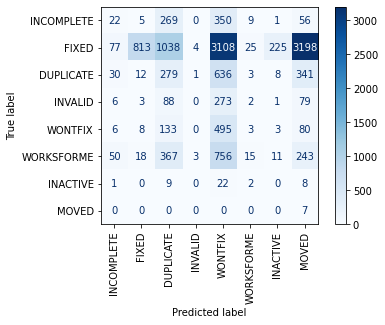

In [9]:
NB_metrics = get_metrics(NB, "Naive Bayes", x_train, y_train, x_test, y_test, classes)

#### Logistic Regression

/local_home/manel_local/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local_home/manel_local/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Logistic Regression Metrics:

Accuracy score is:	0.05%
Precision score is:	0.0%
Recall score is:	0.05%
F1 score is:	0.0%


[[   0    0    0    0    0 1310    0    0]
 [   0    0    0    0    0 8488    0    0]
 [   0    0    0    0    0   42    0    0]
 [   0    0    0    0    0  712    0    0]
 [   0    0    0    0    0  452    0    0]
 [   0    0    0    0    0    7    0    0]
 [   0    0    0    0    0  728    0    0]
 [   0    0    0    0    0 1463    0    0]]


/local_home/manel_local/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local_home/manel_local/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local_home/manel_local/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

   DUPLICATE       0.00      0.00      0.00      1310
       FIXED       0.00      0.00      0.00      8488
    INACTIVE       0.00      0.00      0.00        42
  INCOMPLETE       0.00      0.00      0.00       712
     INVALID       0.00      0.00      0.00       452
       MOVED       0.00      1.00      0.00         7
     WONTFIX       0.00      0.00      0.00       728
  WORKSFORME       0.00      0.00      0.00      1463

    accuracy                           0.00     13202
   macro avg       0.00      0.12      0.00     13202
weighted avg       0.00      0.00      0.00     13202



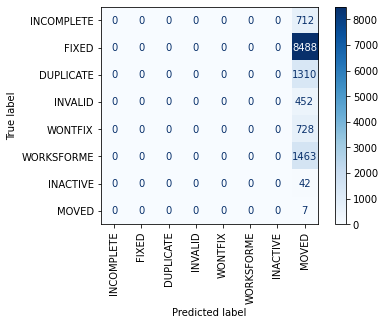

In [10]:
LG_metrics = get_metrics(LG, "Logistic Regression", x_train, y_train, x_test, y_test, classes)

#### Decision Tree

Decision Tree Metrics:

Accuracy score is:	65.5%
Precision score is:	66.23%
Recall score is:	65.5%
F1 score is:	65.86%


[[ 365  363    9   95   99    6  113  260]
 [ 386 7243   13  110  146    7  196  387]
 [   9   13    2    2    2    0    3   11]
 [  97  103    4  291   34    1   58  124]
 [ 101   93    4   38   84    0   45   87]
 [   3    2    0    0    1    0    0    1]
 [ 117  200   12   39   53    1  199  107]
 [ 283  336   14  133   99    4  131  463]]


/local_home/manel_local/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

   DUPLICATE       0.27      0.28      0.27      1310
       FIXED       0.87      0.85      0.86      8488
    INACTIVE       0.03      0.05      0.04        42
  INCOMPLETE       0.41      0.41      0.41       712
     INVALID       0.16      0.19      0.17       452
       MOVED       0.00      0.00      0.00         7
     WONTFIX       0.27      0.27      0.27       728
  WORKSFORME       0.32      0.32      0.32      1463

    accuracy                           0.65     13202
   macro avg       0.29      0.30      0.29     13202
weighted avg       0.66      0.65      0.66     13202



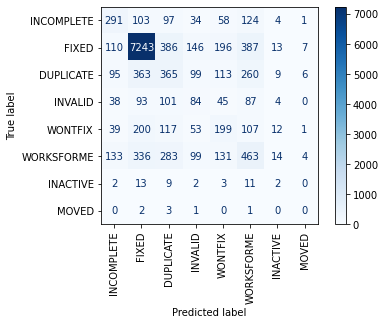

In [11]:
DT_metrics = get_metrics(DT, "Decision Tree", x_train, y_train, x_test, y_test, classes)

#### Random Forest

/Users/macbookproz/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest Metrics:

Accuracy score is:	74.46%
Precision score is:	71.81%
Recall score is:	74.46%
F1 score is:	72.32%


[[ 456  485    0   44   25    0   54  246]
 [ 161 8101    0   19   13    0   44  150]
 [   5   15    1    2    1    0    2   16]
 [  82  107    0  334    8    0   25  156]
 [ 106  132    0   13   75    0   24  102]
 [   3    2    0    0    0    0    0    2]
 [  96  261    0   18    9    0  218  126]
 [ 233  432    1   70   18    0   64  645]]


/Users/macbookproz/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookproz/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookproz/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

              precision    recall  f1-score   support

   DUPLICATE       0.40      0.35      0.37      1310
       FIXED       0.85      0.95      0.90      8488
    INACTIVE       0.50      0.02      0.05        42
  INCOMPLETE       0.67      0.47      0.55       712
     INVALID       0.50      0.17      0.25       452
       MOVED       0.00      0.00      0.00         7
     WONTFIX       0.51      0.30      0.38       728
  WORKSFORME       0.45      0.44      0.44      1463

    accuracy                           0.74     13202
   macro avg       0.48      0.34      0.37     13202
weighted avg       0.72      0.74      0.72     13202



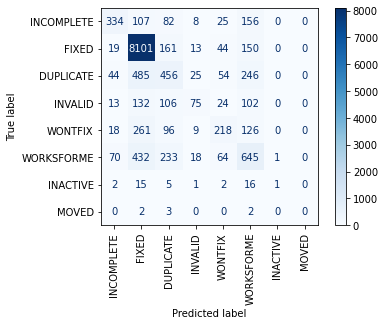

In [9]:
RF_metrics = get_metrics(RF, "Random Forest", x_train, y_train, x_test, y_test, classes)

#### Gradient Boosting

Gradient Boosting Metrics:

Accuracy score is:	65.79%
Precision score is:	73.28%
Recall score is:	65.79%
F1 score is:	68.85%




/local_home/manel_local/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


[[ 448  127   46  122  167   50  158  192]
 [ 479 6872   73   98  217   97  398  254]
 [   3    2   19    3    3    1    3    8]
 [  63   17   18  387   42    6   74  105]
 [  85   23   13   58  147   11   61   54]
 [   2    1    0    0    0    4    0    0]
 [  89   57   46   52   60    8  314  102]
 [ 274  116   67  214  130   35  133  494]]
              precision    recall  f1-score   support

   DUPLICATE       0.31      0.34      0.33      1310
       FIXED       0.95      0.81      0.88      8488
    INACTIVE       0.07      0.45      0.12        42
  INCOMPLETE       0.41      0.54      0.47       712
     INVALID       0.19      0.33      0.24       452
       MOVED       0.02      0.57      0.04         7
     WONTFIX       0.28      0.43      0.34       728
  WORKSFORME       0.41      0.34      0.37      1463

    accuracy                           0.66     13202
   macro avg       0.33      0.48      0.35     13202
weighted avg       0.73      0.66      0.69     13202



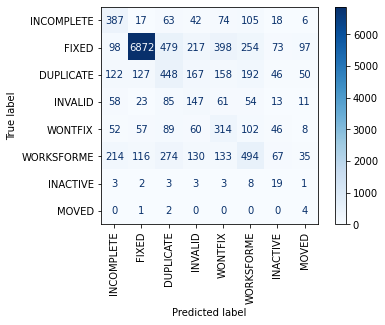

In [13]:
GB_metrics = get_metrics(GB, "Gradient Boosting", x_train, y_train, x_test, y_test, classes)

### Cross Validation

Cross validation model

In [10]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

Naive Bayers

In [ ]:
n_scores_NB = cross_val_score(NB, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores_NB), std(n_scores_NB)))

Logistic Regression

In [ ]:
n_scores_LG = cross_val_score(LG, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores_LG), std(n_scores_LG)))

Random forest
TODO: instance the model again and run it

In [8]:
n_scores_RF = cross_val_score(RF, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores_RF), std(n_scores_RF)))

: 

: 

Gradient Boosting

In [ ]:
#took too much time
#n_scores_GB = cross_val_score(GB, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
#print('Accuracy: %.3f (%.3f)' % (mean(n_scores_GB), std(n_scores_GB)))

### Models Finetunning

Naive Bayers

In [ ]:
NB_tuned_metrics, nb_pred = get_tuned_metrics(NB, "Naive Bayes", 10, x_train, y_train, x_test, y_test, classes)
pickle.dump(NB_tuned_metrics, open('./data/models/NB_tuned_metrics.pkl', 'wb'))
pickle.dump(nb_pred, open('./data/models/nb_pred.pkl', 'wb'))

Logistic Regression

In [ ]:
LG_tuned_metrics, lg_pred = get_tuned_metrics(LG, "Logistic Regression", 10, x_train, y_train, x_test, y_test, classes)
pickle.dump(LG_tuned_metrics, open('./data/models/LG_tuned_metrics.pkl', 'wb'))
pickle.dump(lg_pred, open('./data/models/lg_pred.pkl', 'wb'))

Decision Tree

In [ ]:
DT_tuned_metrics, dt_pred = get_tuned_metrics(DT, "Decision Tree", 10, x_train, y_train, x_test, y_test, classes)
pickle.dump(DT_tuned_metrics, open('./data/models/DT_tuned_metrics.pkl', 'wb'))
pickle.dump(dt_pred, open('./data/models/dt_pred.pkl', 'wb'))

Random Forest

In [ ]:
RF_tuned_metrics, rf_pred = get_tuned_metrics(RF, 'RandomForest', 10, x_train, y_train, x_test, y_test, classes)
pickle.dump(RF_tuned_metrics, open('./data/models/RF_tuned_metrics.pkl', 'wb'))
pickle.dump(rf_pred, open('./data/models/rf_pred.pkl', 'wb'))

Gradient Boosting

In [ ]:
GB_tuned_metrics, gb_pred = get_tuned_metrics(GB, 'Gradient Boosting', 10, x_train, y_train, x_test, y_test, classes)
pickle.dump(GB_tuned_metrics, open('./data/models/GB_tuned_metrics.pkl', 'wb'))
pickle.dump(gb_pred, open('./data/models/gb_pred.pkl', 'wb'))

# Grouping Strategy

TODO

# Random Forest Analysis 

In [7]:
fit_result = RF.fit(x_train, y_train)
pred = RF.predict(x_test)

In [8]:
data_eda = test.copy()
data_eda['predicted'] = pred

In order to check whether the FIXED classifications was right we defined:

In [9]:
def eval_classification(row):
    if ((row['label'] == row['predicted']) & (row['label'] == 'FIXED')):
        return 'right'
    elif ((row['label'] != row['predicted']) & (row['label'] == 'FIXED')):
        return 'wrong'
    else:
        return 'other'

In [10]:
data_eda['classification'] = data_eda.apply(lambda row: eval_classification(row), axis=1)
data_eda.head()


,bg_number,total_users_commenting,total_comments_by_author,has_attachment,total_attachment_comments,changes_severity,changes_priority,changes_assigned,total_changes,total_users_changes,...,op_sys_Other,op_sys_Solaris,op_sys_Unspecified,op_sys_Windows,op_sys_Windows Phone 8,op_sys_iOS,op_sys_macOS,label,predicted,classification
0,990833.0,0,3,False,0,0,1,1,9,2,...,0,0,0,0,0,0,0,WONTFIX,WONTFIX,other
1,1713606.0,6,0,False,3,0,1,1,20,7,...,0,0,1,0,0,0,0,FIXED,FIXED,right
2,1338477.0,1,0,False,2,0,1,1,9,3,...,0,0,1,0,0,0,0,FIXED,FIXED,right
3,1032077.0,0,1,False,0,1,1,0,5,2,...,0,0,0,0,0,0,0,INVALID,WONTFIX,other
4,1124266.0,3,0,False,2,0,1,1,7,2,...,0,0,0,0,0,0,1,FIXED,FIXED,right


In [11]:
data_eda.to_csv('../data/data_eda.csv')

In [18]:
data_eda = pd.read_csv('../data/data_eda.csv')

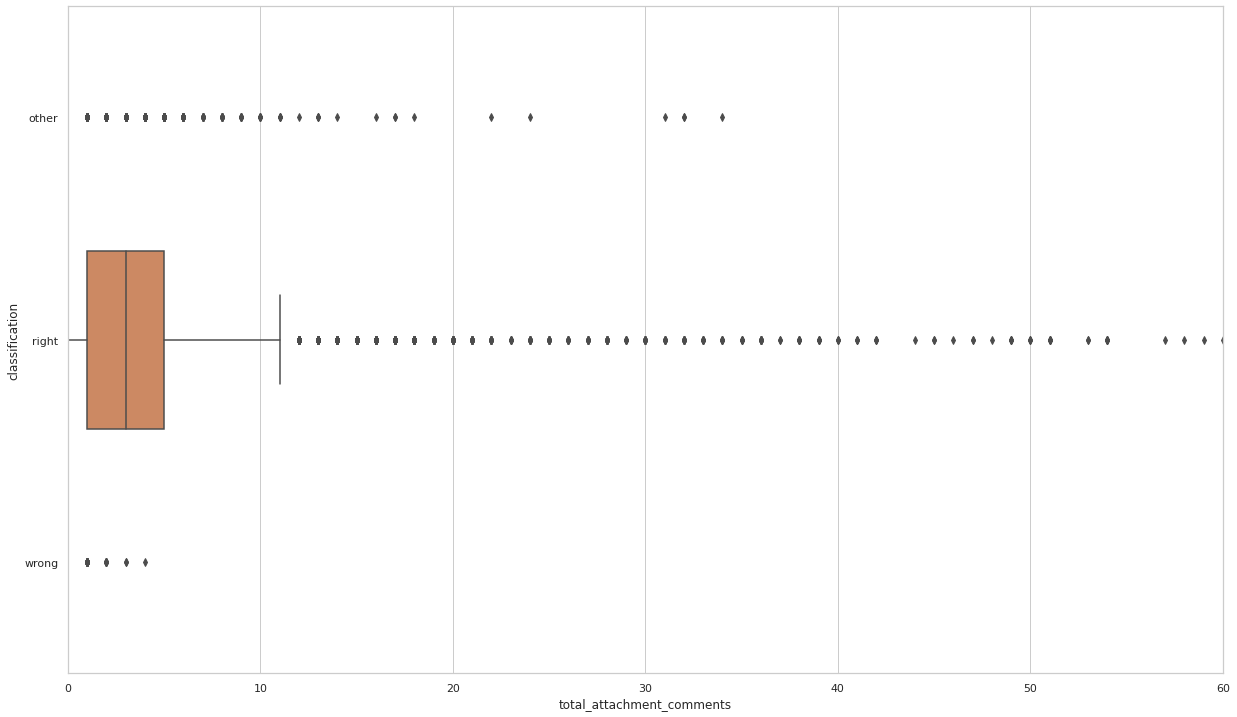

In [13]:
sns.set(rc={"figure.figsize":(20.7, 12.27)})
sns.set_style('whitegrid')


ax= sns.boxplot(x='total_attachment_comments',y='classification',data=data_eda).set(xlim=(0, 60))

In [23]:
len(data_eda[data_eda['classification'] == 'wrong'])

387

INCOMPLETE

In [38]:
data_eda_incomplete = data_eda[(data_eda['label'] == 'INCOMPLETE')][(data_eda["label"] == data_eda["predicted"])]
data_eda_incomplete_wrong = data_eda[(data_eda['label'] == 'INCOMPLETE')][(data_eda["label"] != data_eda["predicted"])]

/tmp/ipykernel_20881/440639897.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_eda_incomplete = data_eda[(data_eda['label'] == 'INCOMPLETE')][(data_eda["label"] == data_eda["predicted"])]
/tmp/ipykernel_20881/440639897.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_eda_incomplete_wrong = data_eda[(data_eda['label'] == 'INCOMPLETE')][(data_eda["label"] != data_eda["predicted"])]


Data summary

- Tamanho dos comentários
- Descrição dos comentários
- Quantidade de palavras impactam?
- Qual a relação dos comentários com outras variáveis?
- Os classificados de forma correta têm mais mudanças(total_changes)?

In [16]:
data_eda_incomplete.describe()

,bg_number,total_users_commenting,total_comments_by_author,total_attachment_comments,changes_severity,changes_priority,changes_assigned,total_changes,total_users_changes,severity,...,op_sys_OS/2,op_sys_OpenBSD,op_sys_OpenSolaris,op_sys_Other,op_sys_Solaris,op_sys_Unspecified,op_sys_Windows,op_sys_Windows Phone 8,op_sys_iOS,op_sys_macOS
count,3.340000e+02,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,...,334.0,334.0,334.0,334.0,334.0,334.000000,334.000000,334.0,334.0,334.000000
mean,1.169130e+06,2.005988,0.389222,0.053892,0.200599,0.934132,0.008982,4.026946,2.931138,2.413174,...,0.0,0.0,0.0,0.0,0.0,0.655689,0.200599,0.0,0.0,0.044910
std,1.957633e+05,1.651269,1.289134,0.295258,0.541269,0.601677,0.122205,3.023808,1.582009,0.803487,...,0.0,0.0,0.0,0.0,0.0,0.475856,0.401049,0.0,0.0,0.207418
min,7.173860e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
25%,1.071312e+06,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,2.000000,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
50%,1.283438e+06,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,3.000000,2.000000,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.000000
75%,1.297250e+06,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,5.000000,3.000000,2.000000,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.000000
max,1.533753e+06,14.000000,12.000000,2.000000,4.000000,4.000000,2.000000,23.000000,20.000000,4.000000,...,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,1.000000


In [21]:
data_eda_incomplete_wrong.describe()

,bg_number,total_users_commenting,total_comments_by_author,total_attachment_comments,changes_severity,changes_priority,changes_assigned,total_changes,total_users_changes,severity,...,op_sys_OS/2,op_sys_OpenBSD,op_sys_OpenSolaris,op_sys_Other,op_sys_Solaris,op_sys_Unspecified,op_sys_Windows,op_sys_Windows Phone 8,op_sys_iOS,op_sys_macOS
count,3.780000e+02,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,...,378.0,378.0,378.0,378.0,378.0,378.000000,378.000000,378.0,378.000000,378.000000
mean,1.079898e+06,2.981481,2.050265,0.560847,0.291005,0.703704,0.314815,7.579365,3.582011,2.822751,...,0.0,0.0,0.0,0.0,0.0,0.219577,0.325397,0.0,0.002646,0.105820
std,2.542410e+05,2.441284,3.765699,2.134161,0.540138,0.715154,0.776883,6.513019,2.129718,1.044277,...,0.0,0.0,0.0,0.0,0.0,0.414509,0.469144,0.0,0.051434,0.308015
min,7.185750e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
25%,8.696555e+05,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
50%,1.053243e+06,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,6.000000,3.000000,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
75%,1.253133e+06,4.000000,2.000000,0.000000,1.000000,1.000000,0.000000,10.000000,4.000000,4.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.000000
max,1.745426e+06,14.000000,38.000000,32.000000,4.000000,4.000000,7.000000,50.000000,12.000000,4.000000,...,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0,1.000000,1.000000


<AxesSubplot:xlabel='label'>

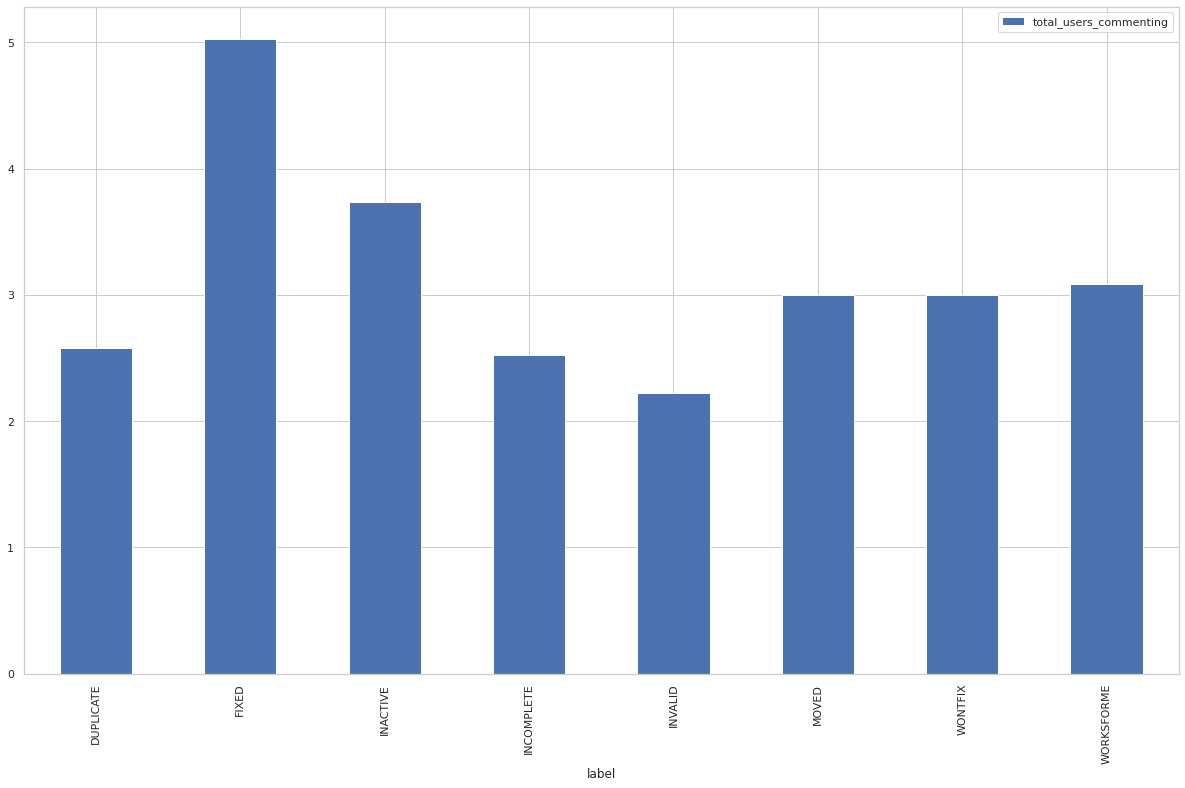

In [24]:
data_eda[['label', 'total_users_commenting']].groupby('label').mean().plot.bar(y='total_users_commenting')

<AxesSubplot:xlabel='label'>

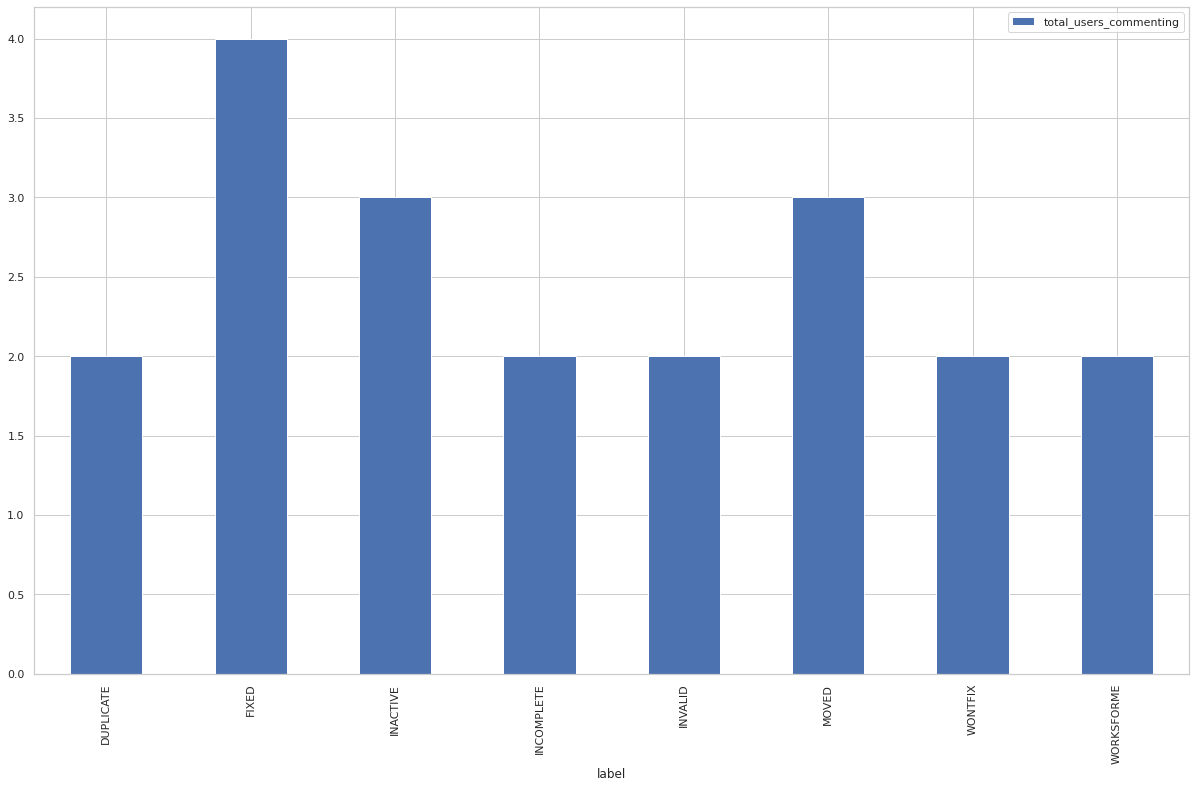

In [40]:
data_eda_plot = data_eda[['label', 'total_users_commenting']].groupby('label').median()
data_eda_plot.plot.bar(y='total_users_commenting')

In [32]:
data_eda[data_eda['label']== 'INCOMPLETE'][['label', 'total_users_commenting']].groupby('label').mean() 

,total_users_commenting
label,
INCOMPLETE,2.523876


In [26]:
data_eda_incomplete_wrong[['label', 'total_users_commenting']].groupby('label').mean()

,total_users_commenting
label,
INCOMPLETE,2.981481


In [27]:
data_eda_incomplete[['label', 'total_users_commenting']].groupby('label').mean()

,total_users_commenting
label,
INCOMPLETE,2.005988


In [37]:
data_eda[(data_eda['label'] == 'INCOMPLETE')][(data_eda["predicted"] == 'WORKSFORME')][['label', 'total_users_commenting']].groupby('label').mean()

/tmp/ipykernel_20881/901845585.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_eda[(data_eda['label'] == 'INCOMPLETE')][(data_eda["predicted"] == 'WORKSFORME')][['label', 'total_users_commenting']].groupby('label').mean()


,total_users_commenting
label,
INCOMPLETE,2.724359


In [58]:
df = data_eda[['label', 'total_users_commenting']].groupby('label').mean()
df['median'] = data_eda[['label', 'total_users_commenting']].groupby('label').median()['total_users_commenting']
df

,total_users_commenting,median
label,,
DUPLICATE,2.580916,2.0
FIXED,5.029571,4.0
INACTIVE,3.738095,3.0
INCOMPLETE,2.523876,2.0
INVALID,2.225664,2.0
MOVED,3.000000,3.0
WONTFIX,3.002747,2.0
WORKSFORME,3.084757,2.0


In [54]:
data_eda[['label', 'total_users_commenting']].groupby('label').median()['total_users_commenting']

label
DUPLICATE     2.0
FIXED         4.0
INACTIVE      3.0
INCOMPLETE    2.0
INVALID       2.0
MOVED         3.0
WONTFIX       2.0
WORKSFORME    2.0
Name: total_users_commenting, dtype: float64

<AxesSubplot:xlabel='label'>

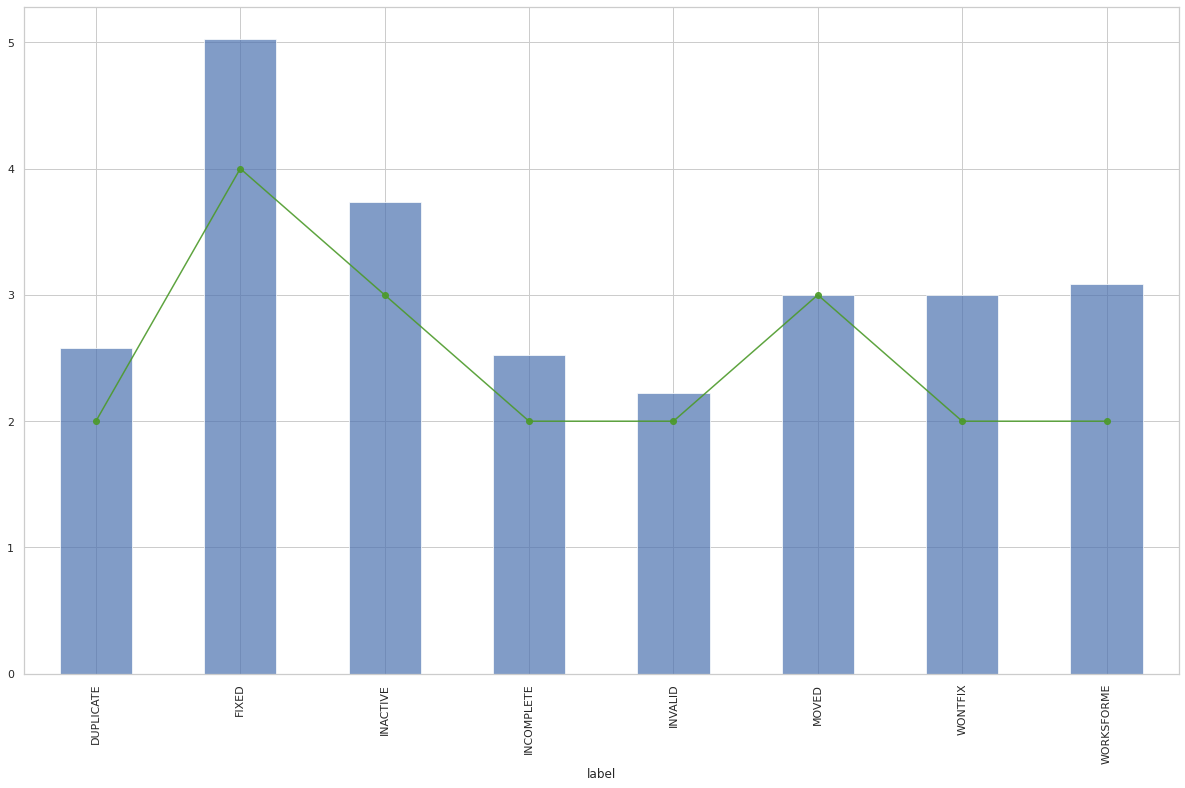

In [72]:
fig, ax = plt.subplots()
df['median'].plot(ax=ax, marker='o', ls='-', color='#4C9A2A', alpha = 0.9)
df['total_users_commenting'].plot(kind='bar', ax=ax, alpha=0.7)